In [1]:
# packages

# standard
import numpy as np
import pandas as pd
import time

# mne
import mne

# plots
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# configs
pd.set_option('display.max_columns', None) # we want to display all columns in this notebook

# aesthetics
default_color_1 = 'darkblue'
default_color_2 = 'darkgreen'
default_color_3 = 'darkred'

<a id='train'></a>
# Training File

In [3]:
# training data - load and preview
df_train = pd.read_csv('../input/hms-harmful-brain-activity-classification/train.csv')
df_train.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [4]:
# votes columns
features_vote = ['seizure_vote', 'lpd_vote', 'gpd_vote',
                 'lrda_vote', 'grda_vote', 'other_vote']

In [5]:
# group by eeg_id to get just one row per EEG
df_train_unique_votes = df_train.groupby('eeg_id')[features_vote].mean()

# calc sum of votes for each row
df_train_unique_votes['vote_sum'] = df_train_unique_votes[features_vote].sum(axis=1)

# normalize votes (=> 100% distribution for each row/EEG)
for f in features_vote:
    df_train_unique_votes[f] = df_train_unique_votes[f] / df_train_unique_votes.vote_sum
    
df_train_unique_votes.head(10)

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,vote_sum
eeg_id,,,,,,,
568657,0.000000,0.000000,0.25,0.000000,0.166667,0.583333,12.0
582999,0.000000,0.857143,0.00,0.071429,0.000000,0.071429,14.0
642382,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,1.0
751790,0.000000,0.000000,1.00,0.000000,0.000000,0.000000,1.0
778705,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,2.0
1629671,1.000000,0.000000,0.00,0.000000,0.000000,0.000000,3.0
1895581,0.076923,0.000000,0.00,0.000000,0.076923,0.846154,13.0
2061593,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,1.0
2078097,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,2.0


<a id='ex_EEG'></a>
# EEG File Example

In [6]:
# load an EEG file
df_eeg = pd.read_parquet('../input/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet')

In [7]:
# preview
df_eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,-43.270000,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,61.000000,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,4.180000,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117


In [8]:
# show structure
df_eeg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fp1     10000 non-null  float32
 1   F3      10000 non-null  float32
 2   C3      10000 non-null  float32
 3   P3      10000 non-null  float32
 4   F7      10000 non-null  float32
 5   T3      10000 non-null  float32
 6   T5      10000 non-null  float32
 7   O1      10000 non-null  float32
 8   Fz      10000 non-null  float32
 9   Cz      10000 non-null  float32
 10  Pz      10000 non-null  float32
 11  Fp2     10000 non-null  float32
 12  F4      10000 non-null  float32
 13  C4      10000 non-null  float32
 14  P4      10000 non-null  float32
 15  F8      10000 non-null  float32
 16  T4      10000 non-null  float32
 17  T6      10000 non-null  float32
 18  O2      10000 non-null  float32
 19  EKG     10000 non-null  float32
dtypes: float32(20)
memory usage: 781.4 KB


In [9]:
# basis stats
df_eeg.describe()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-34.652176,-10.938655,-13.130096,-11.532683,-13.681986,-19.996176,-12.784777,-20.799709,-5.201674,-6.507339,-17.611294,-16.726524,0.557746,-21.673672,-36.212128,14.523577,5.717173,-19.428684,-3.457283,15.943558
std,50.664436,54.227734,58.496956,52.669693,61.517796,53.165680,54.273331,43.390774,44.687992,47.822716,49.587502,48.962845,57.199883,57.287605,55.543560,55.142666,55.865898,119.250450,181.184021,3053.213379
min,-204.529999,-161.149994,-168.339996,-149.820007,-173.029999,-148.000000,-131.759995,-136.779999,-146.199997,-148.679993,-155.199997,-167.600006,-152.330002,-156.820007,-172.270004,-147.369995,-125.279999,-249.190002,-326.049988,-4936.430176
25%,-74.690002,-56.772500,-63.412499,-56.430000,-67.365000,-65.989998,-63.764998,-56.490002,-38.309999,-44.685000,-58.332500,-54.230000,-48.442499,-71.432501,-83.072500,-30.320000,-43.145000,-133.154995,-180.807503,-3091.449890
50%,-35.575001,-11.450000,-12.970000,-11.840000,-14.160000,-20.290001,-12.180000,-21.360001,-5.930000,-6.515000,-17.620000,-17.100000,0.350000,-21.050000,-37.295000,14.350000,5.560000,-19.240000,2.695000,16.080000
75%,7.377500,36.080002,38.369999,33.919998,40.514998,26.262500,37.982500,15.972500,29.379999,32.842500,23.974999,22.422500,49.922499,28.492500,9.652500,60.200001,54.775001,93.754999,175.419994,3127.127563
max,113.750000,131.250000,127.580002,117.730003,167.529999,118.580002,106.660004,90.889999,118.470001,116.339996,101.800003,125.459999,142.360001,119.010002,118.370003,166.139999,145.039993,227.529999,304.549988,4960.529785


In [10]:
# list of features
features_eeg = ['Fp1', 'F3', 'C3', 'P3', 'F7', 
                'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
                'Fp2', 'F4', 'C4', 'P4', 'F8',
                'T4', 'T6', 'O2', 'EKG']

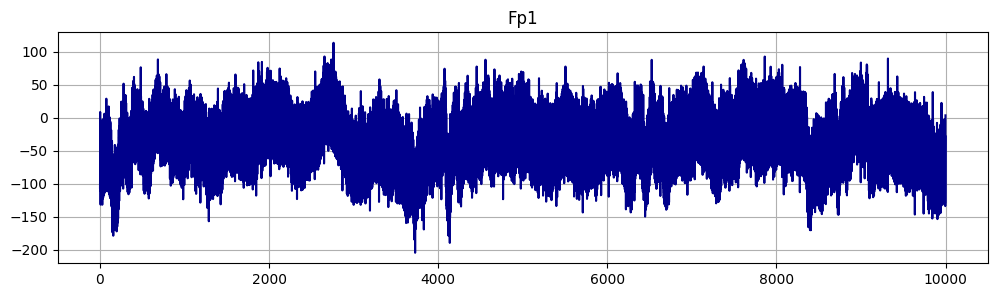

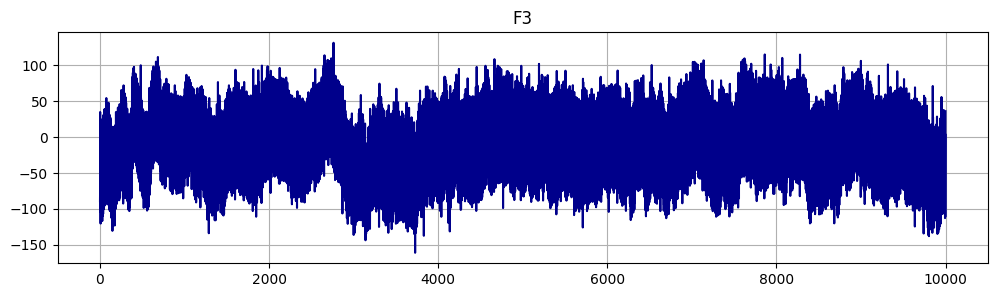

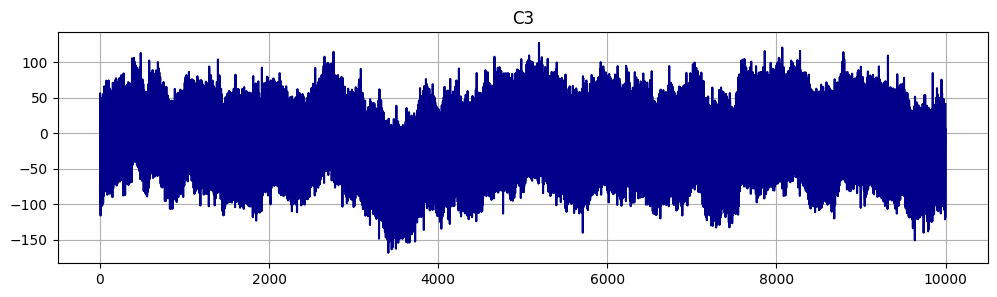

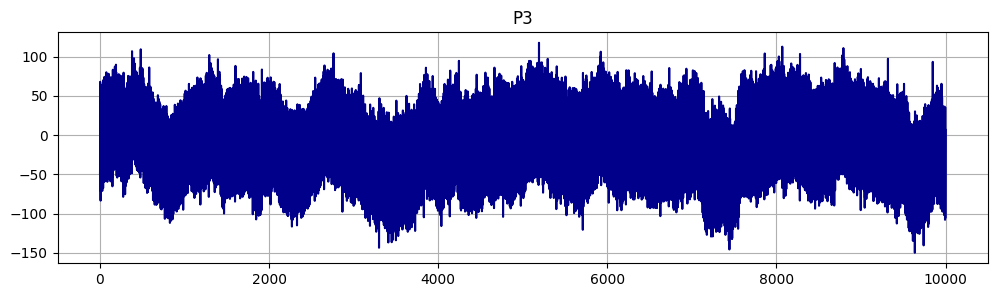

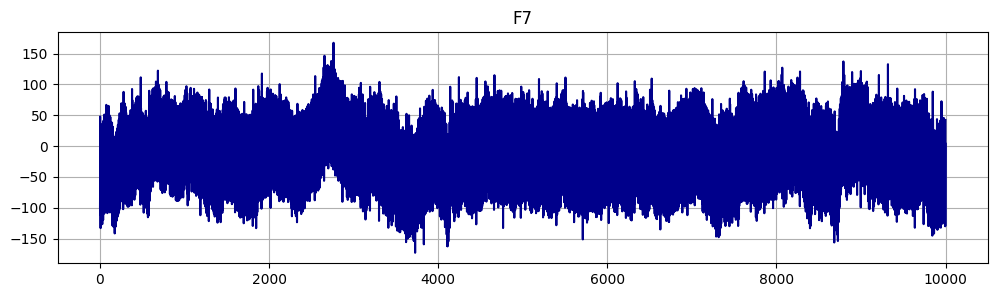

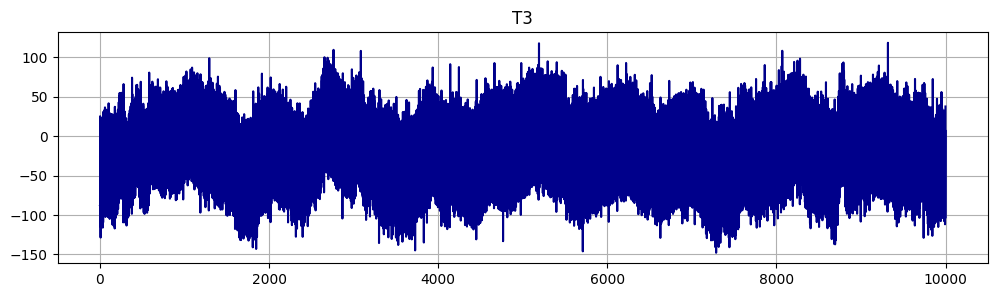

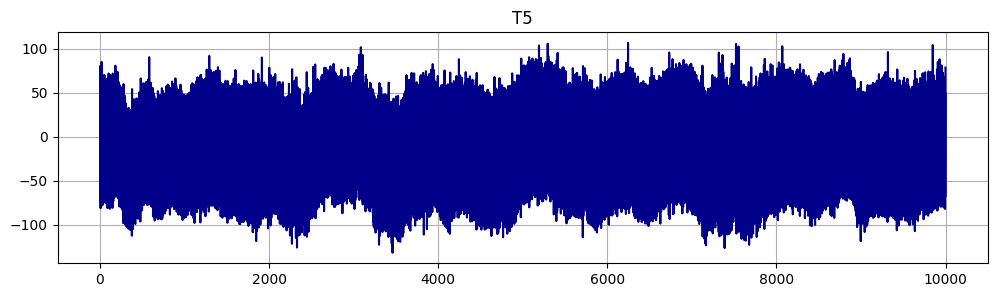

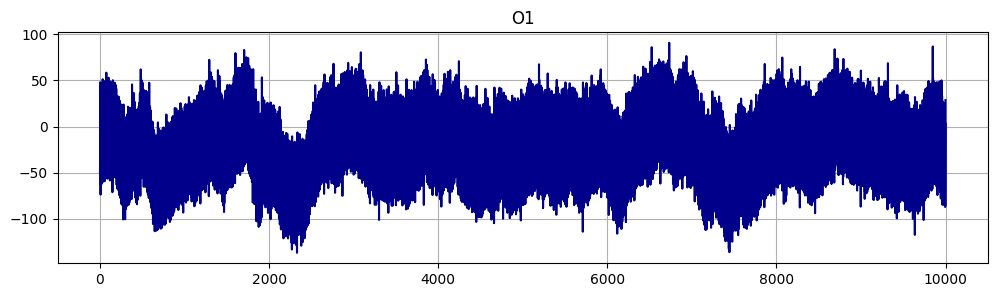

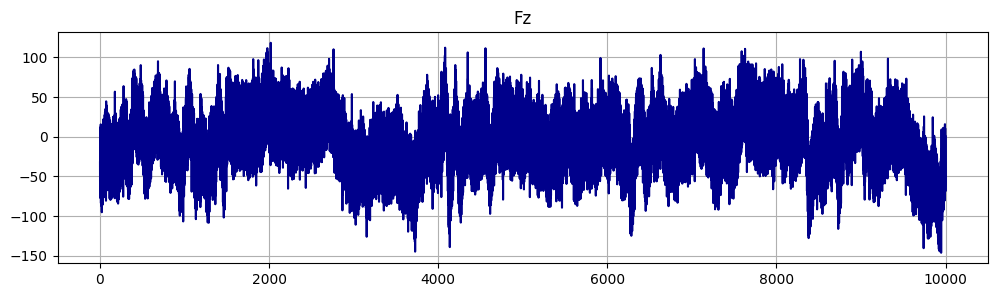

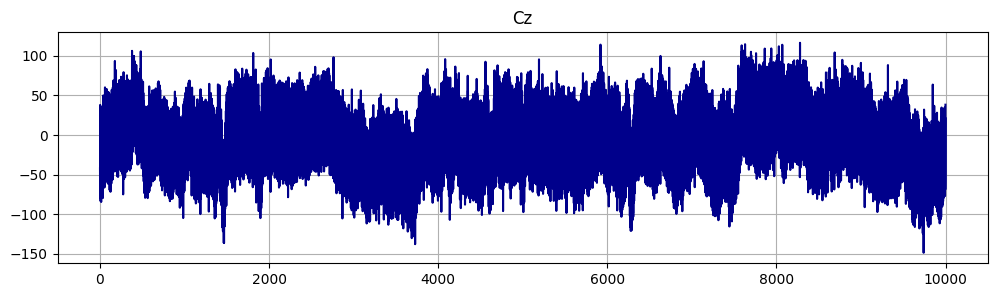

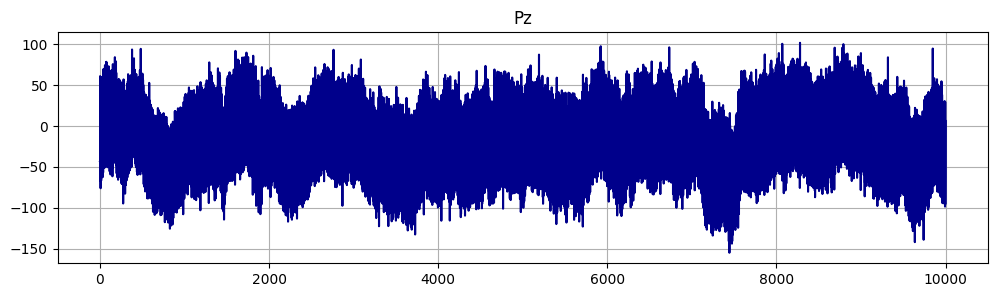

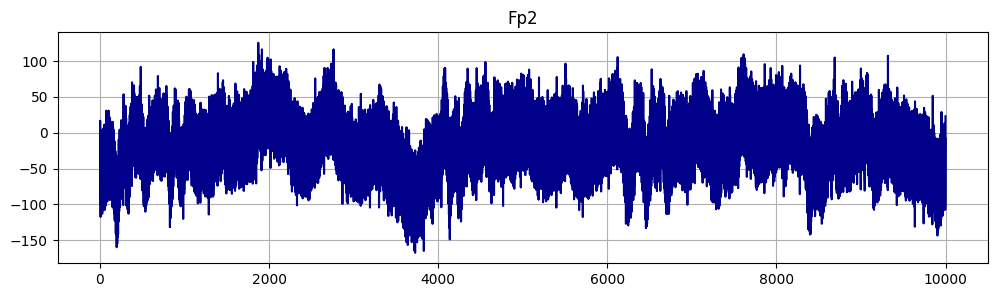

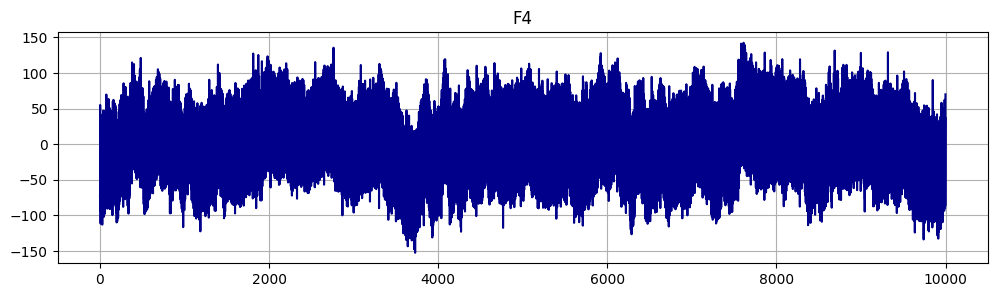

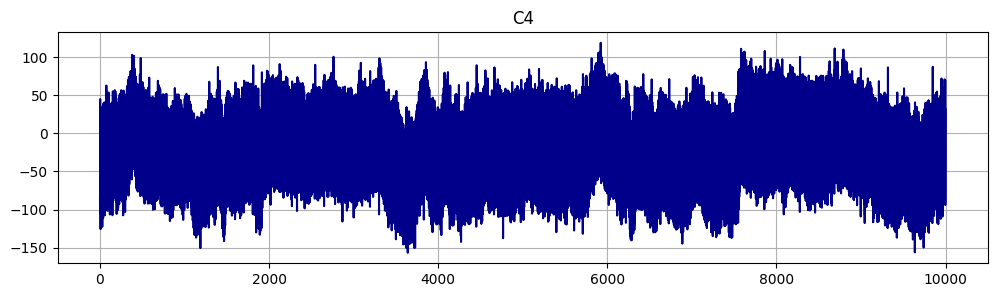

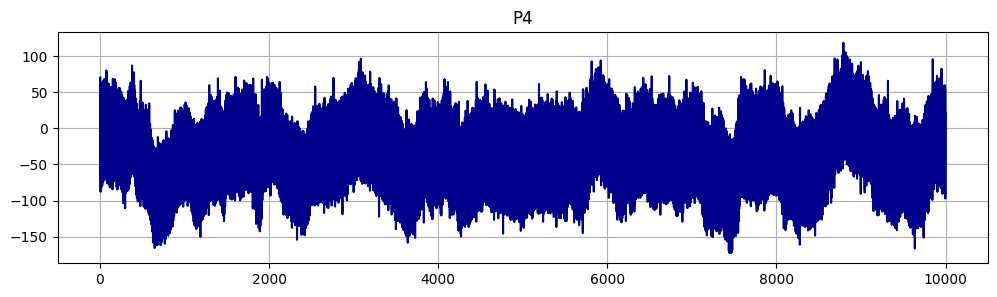

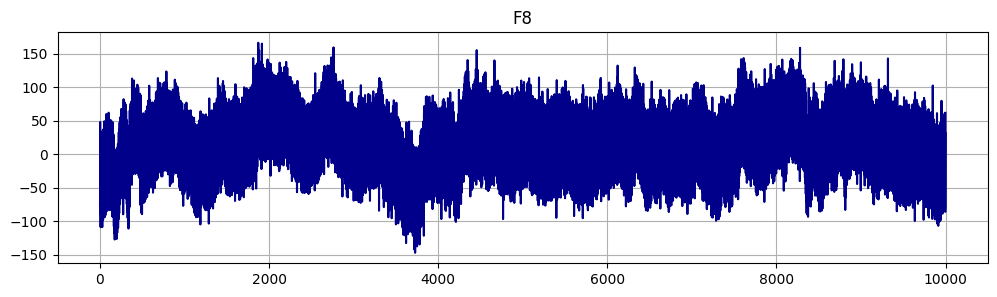

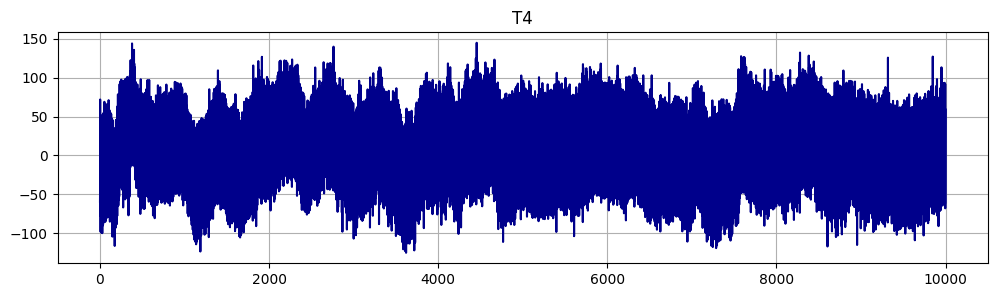

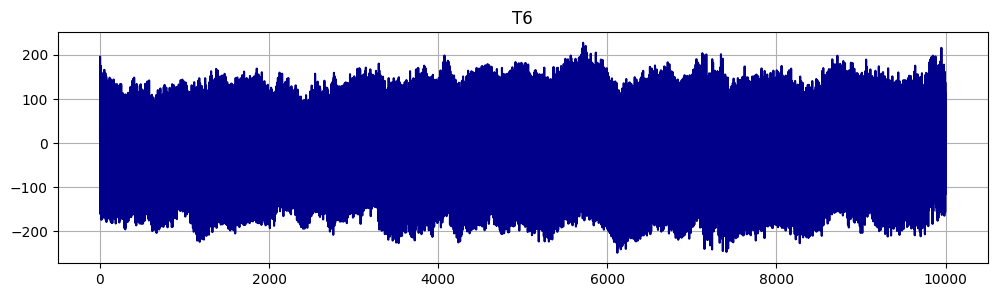

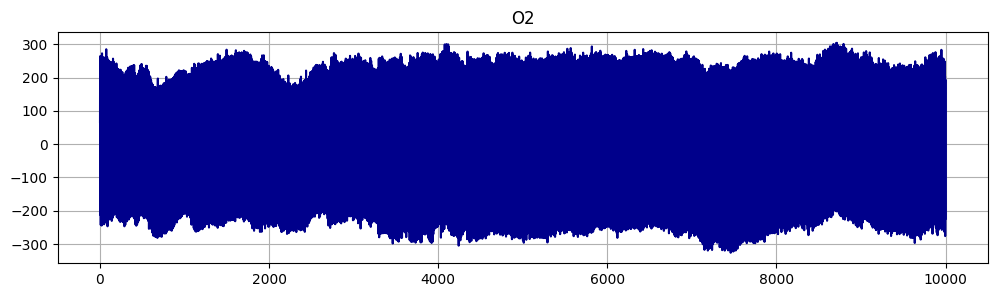

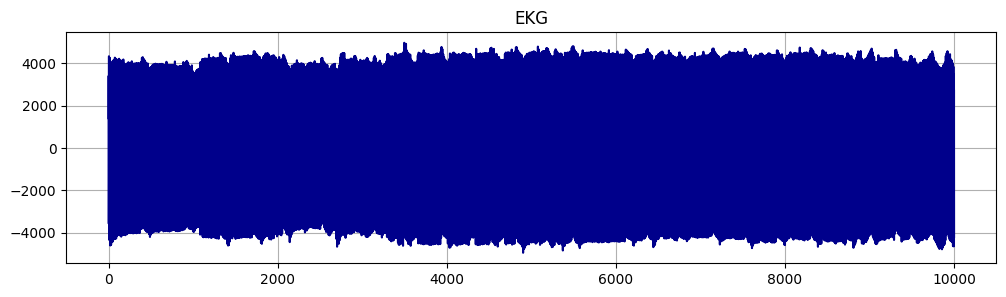

In [11]:
# plot all features - time series
for f in features_eeg:
    plt.figure(figsize=(12,3))
    plt.plot(df_eeg[f], color=default_color_1)
    plt.title(f)
    plt.grid()
    plt.show()

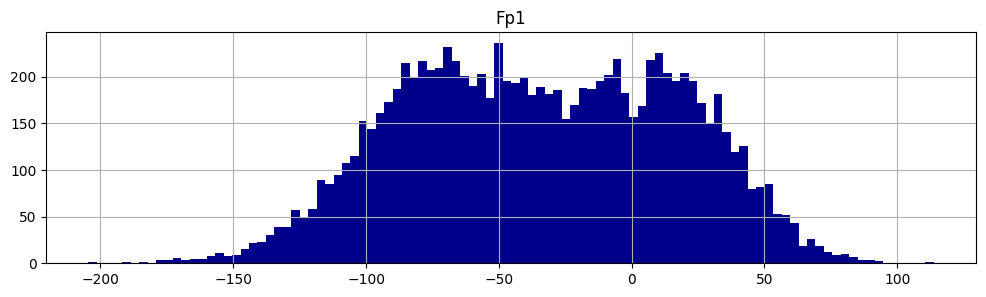

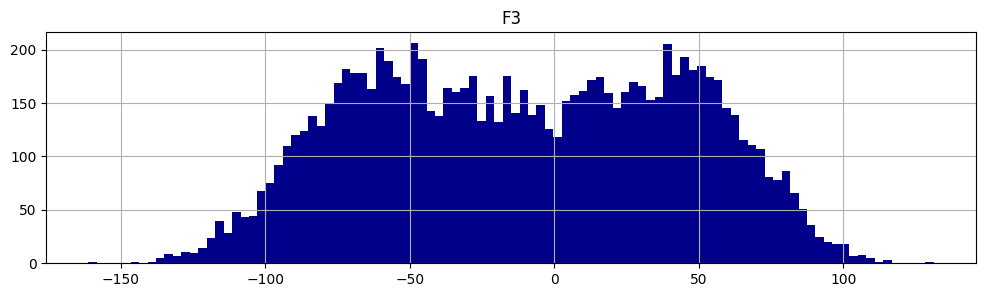

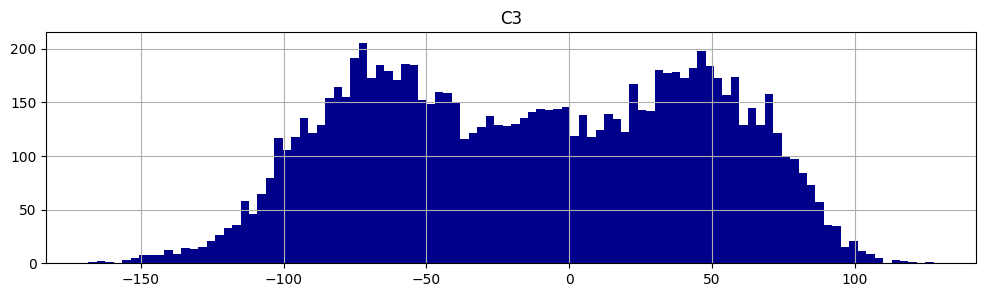

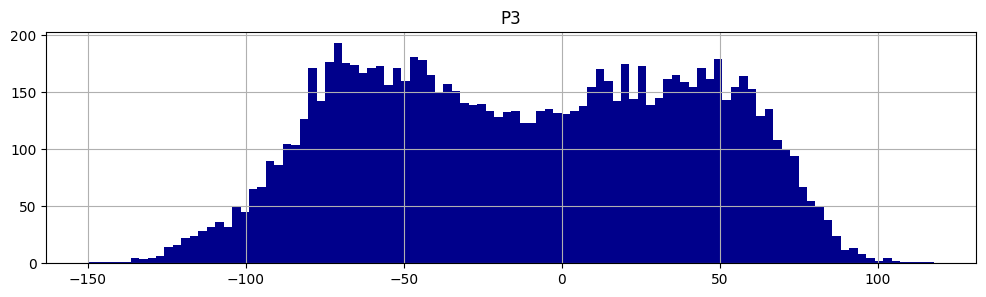

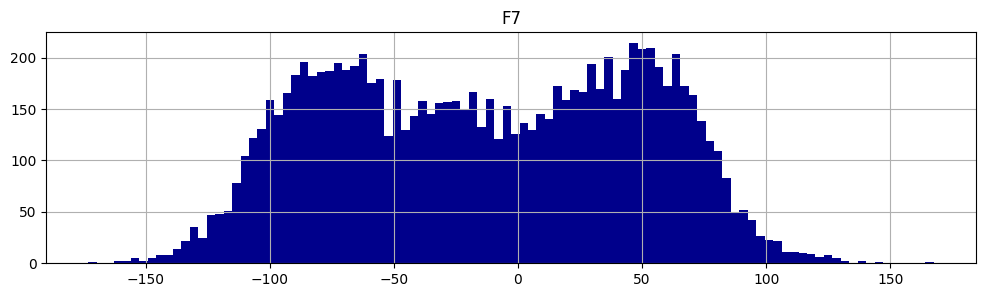

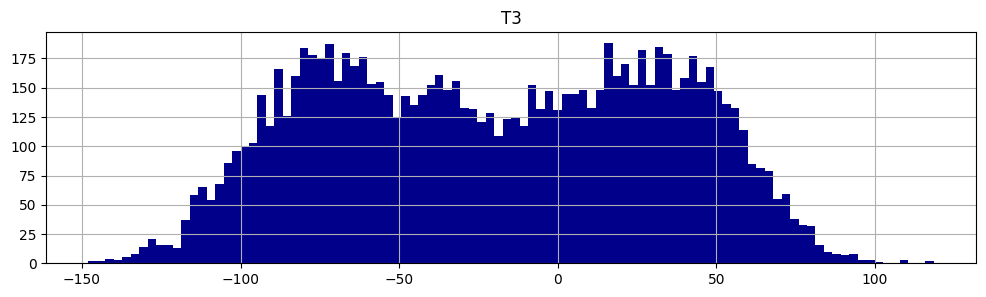

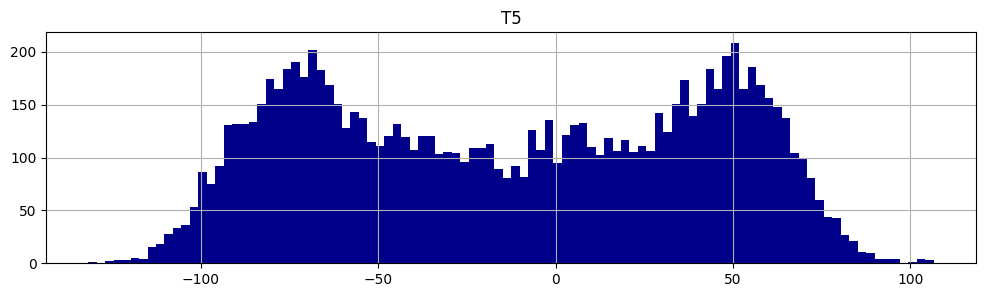

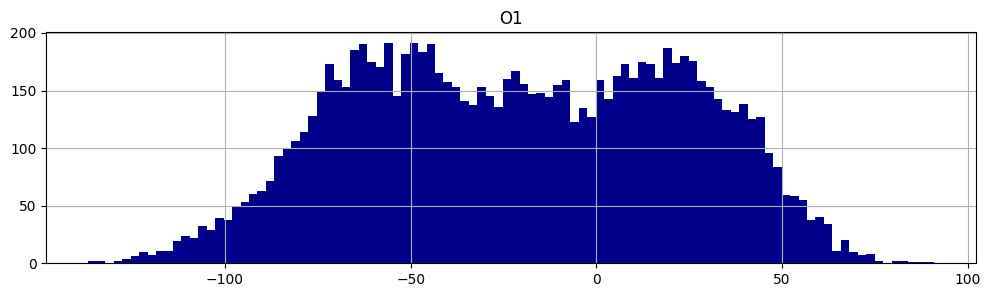

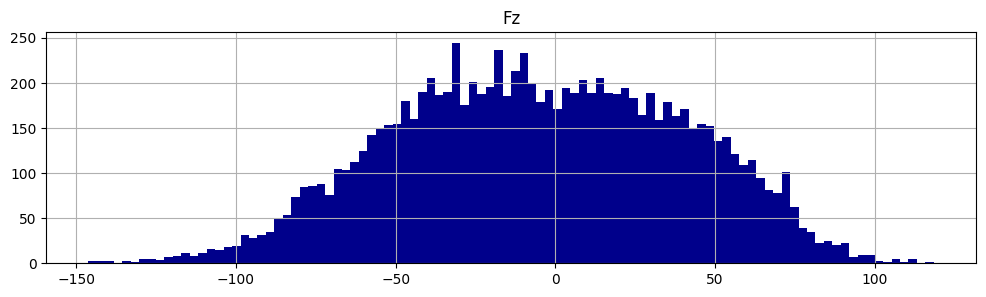

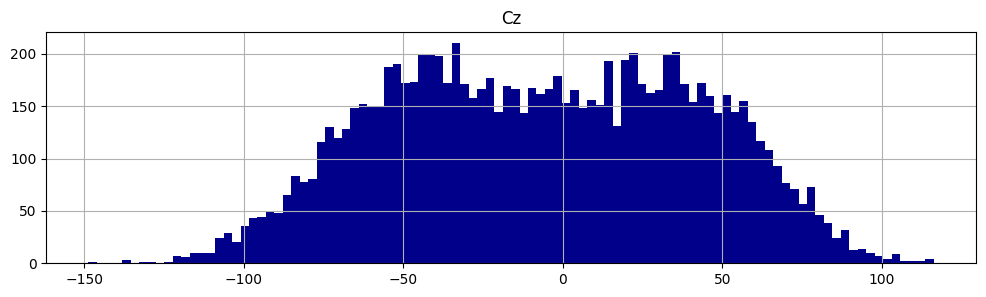

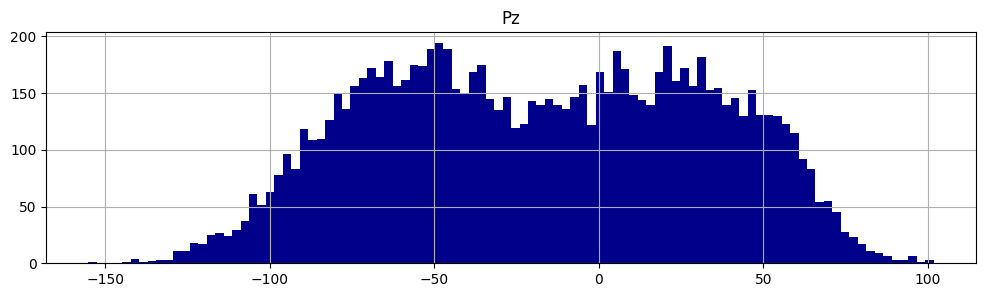

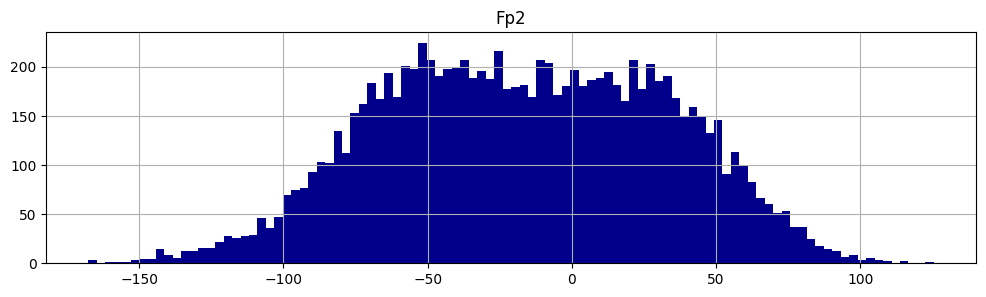

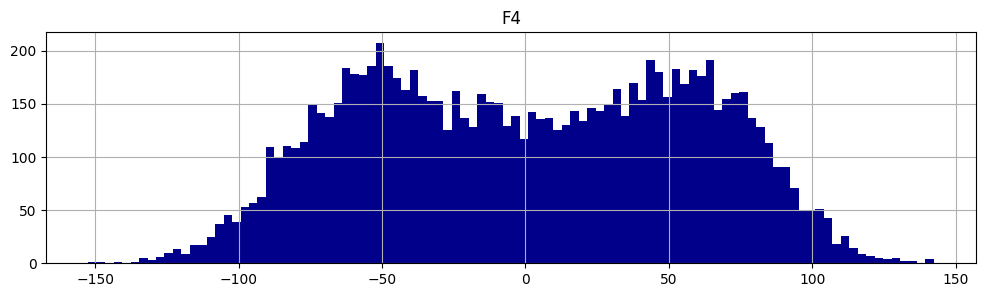

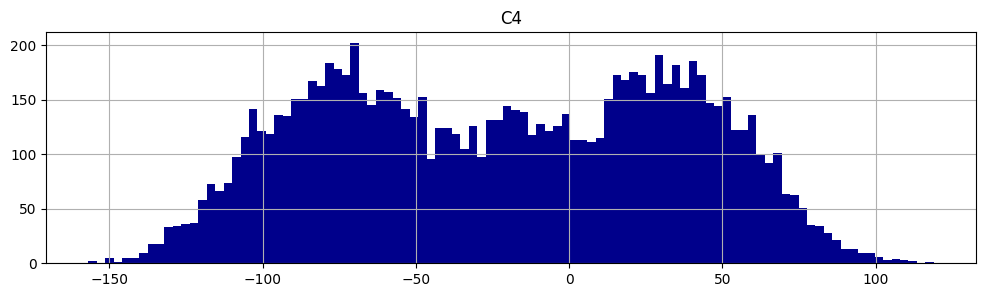

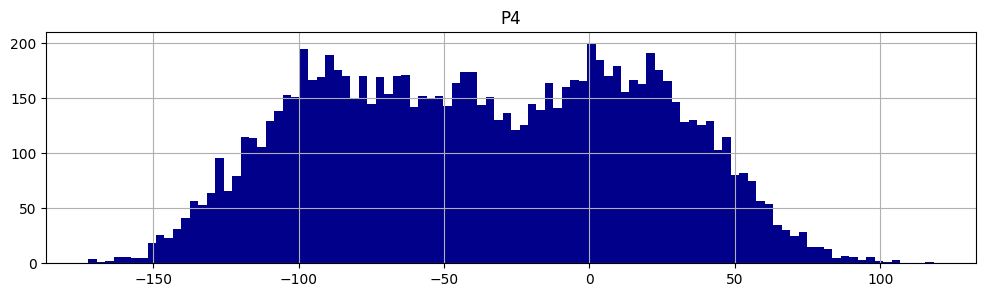

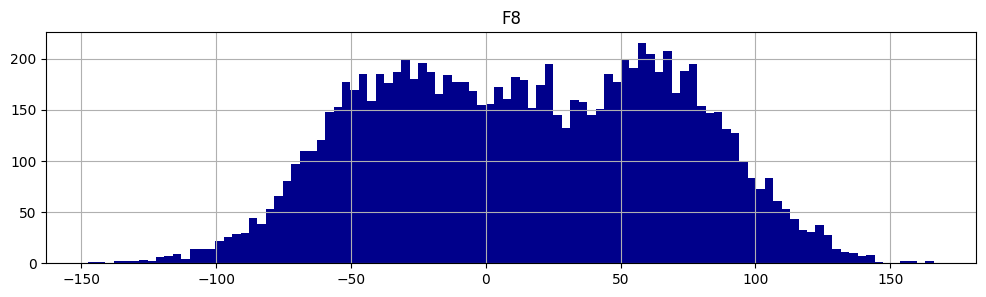

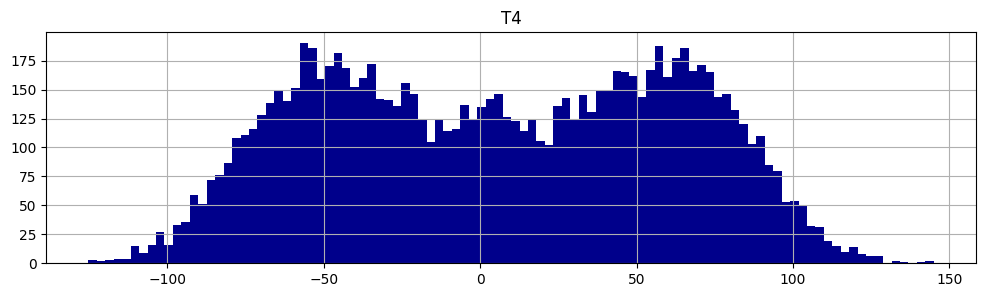

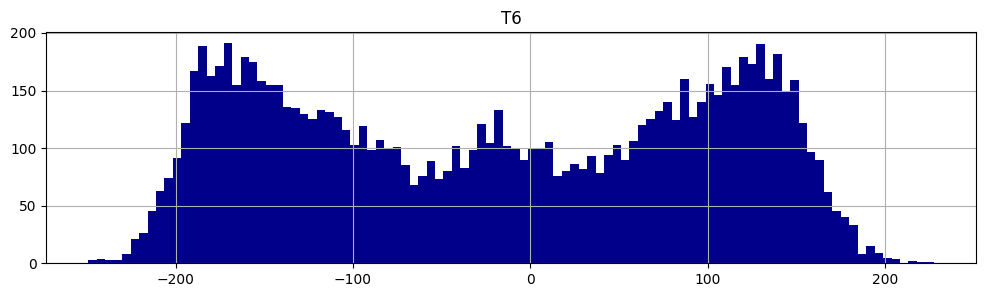

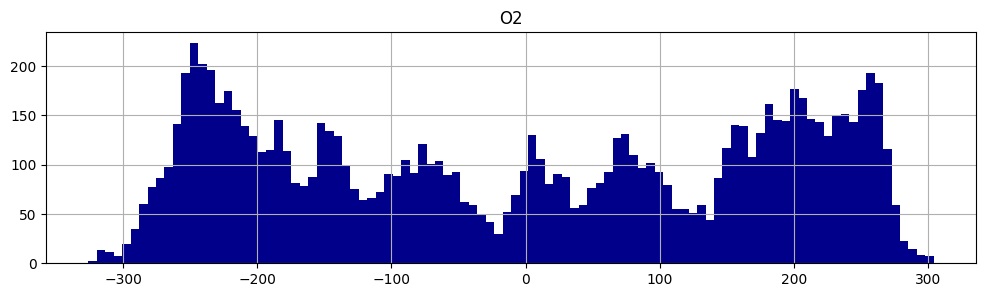

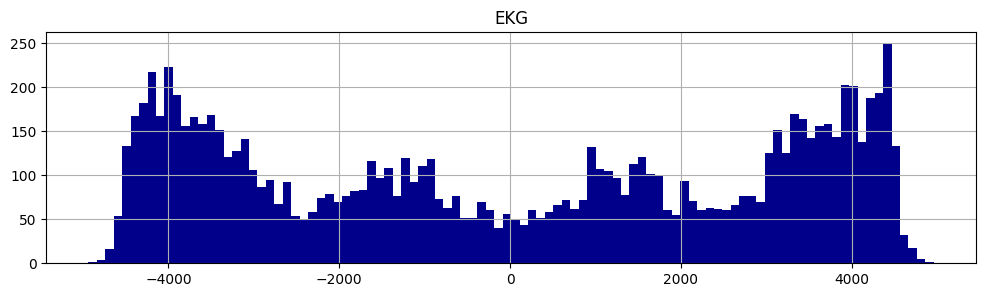

In [12]:
# plot all features - distributions
for f in features_eeg:
    plt.figure(figsize=(12,3))
    plt.hist(df_eeg[f], bins=100,
             color=default_color_1)
    plt.title(f)
    plt.grid()
    plt.show()

# MNEを用いた場合

In [31]:
# サンプリング周波数を設定する
freq = 200

# チャンネル名を設定する
ch_names = df_eeg.columns.to_list()

# データを設定する
data = df_eeg.to_numpy().T

data

array([[-1.05850e+02, -8.54700e+01,  8.84000e+00, ..., -1.33760e+02,
        -7.88900e+01,  3.78000e+00],
       [-8.92300e+01, -7.50700e+01,  3.48500e+01, ..., -1.11190e+02,
        -5.96600e+01,  3.60100e+01],
       [-7.94600e+01, -6.02600e+01,  5.64300e+01, ..., -1.19180e+02,
        -6.07700e+01,  4.10600e+01],
       ...,
       [ 8.21000e+00,  1.96190e+02, -6.71800e+01, ..., -1.48800e+01,
         1.37560e+02, -1.15550e+02],
       [ 6.64900e+01,  2.30670e+02, -1.71310e+02, ...,  6.64400e+01,
         1.93840e+02, -2.24050e+02],
       [ 1.40493e+03,  3.40267e+03, -3.56580e+03, ...,  1.66780e+03,
         2.74338e+03, -4.18560e+03]], dtype=float32)

In [32]:
# MNE形式に変換する
info = mne.create_info(ch_names = ch_names, sfreq = freq, ch_types = 'eeg')
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=20, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.


In [33]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,20 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


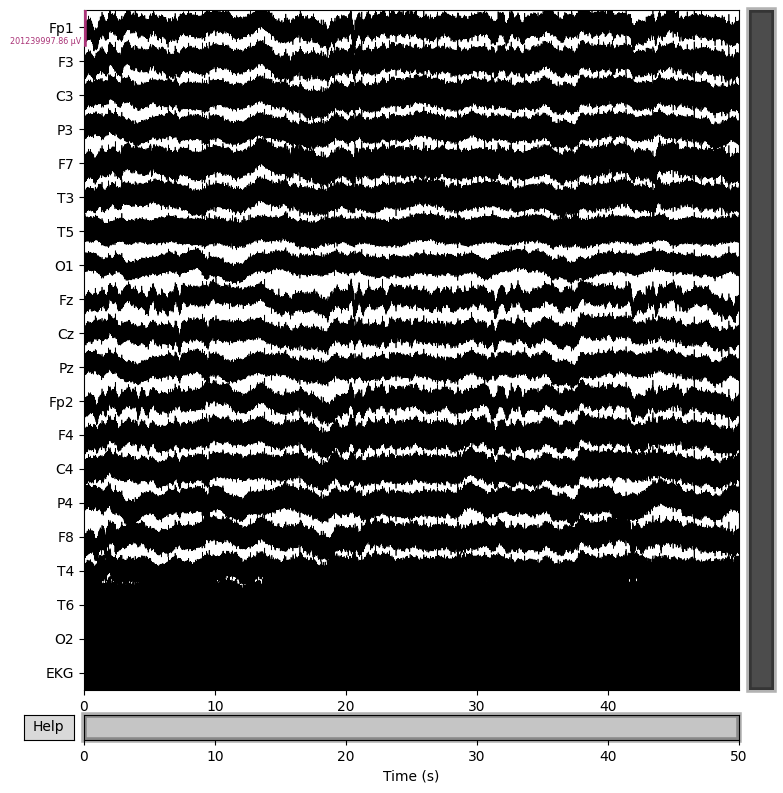

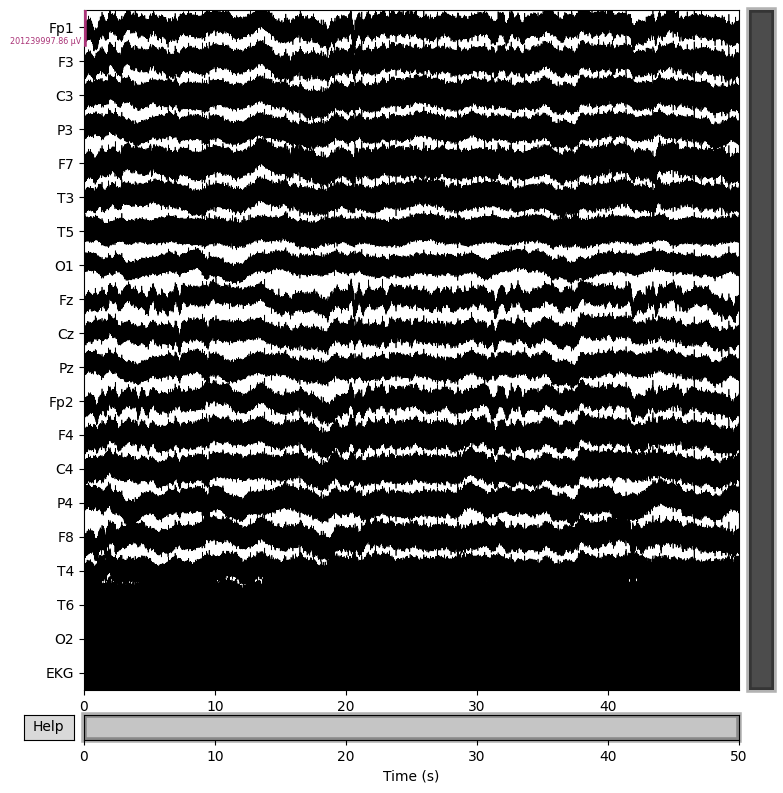

In [34]:
raw.plot(duration=500, n_channels=20, scalings = 'auto')

In [35]:
raw.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,20 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


Effective window size : 10.240 (s)


c:\Users\takashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


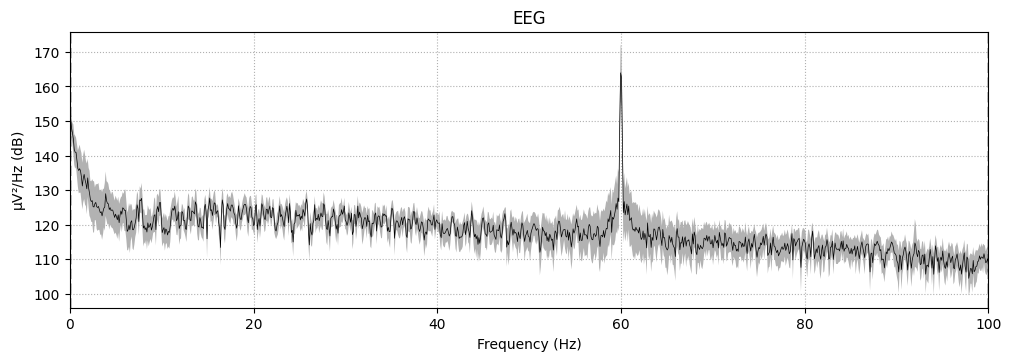

In [37]:
fig = raw.compute_psd(tmax=np.inf, fmax=100).plot(
    average=True, picks="data", exclude="bads"
)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(
            x=freqs[idx],
            y=psds[idx] + 18,
            dx=0,
            dy=-12,
            color="red",
            width=0.1,
            head_width=3,
            length_includes_head=True,
        )

# Scipyを用いた場合

In [38]:
from scipy import signal

# 信号列の抽出
signal_data = df_eeg['Fp1'].values

# バンドパスフィルタを適用する
fs = 1000 # サンプリング周波数
lowcut = 0.5 # 低周波帯域
highcut = 100 # 高周波帯域
order = 4 # フィルタ次数

b, a = signal.butter(order, [lowcut, highcut], btype = 'band', fs = fs)
filtered_signal = signal.filtfilt(b, a, signal_data)

# アーティファクト除去をおこなう
from sklearn.decomposition import FastICA
ica = FastICA(n_components=20)
ica_signal = ica.fit_transform(filtered_signal.reshape(-1, 1))
ica_signal = ica_signal.flatten()

# リファレンスをおこなう
ref_signal = df_eeg['Fp1'].values
ref_signal = ref_signal - ref_signal.mean() # 平均参照
re_referenced_signal = filtered_signal - ref_signal

# エポック分割をおこなう
epoch_length = 1000 # エポックの長さ（ミリ秒）
epochs = []
for i in range(0, len(re_referenced_signal), epoch_length):
    epoch = re_referenced_signal[i: i + epoch_length]
    epochs.append(epoch)

# ノイズ除去をおこなう
for i in range(len(epochs)):
    epochs[i] = signal.detrend(epochs[i])

# ベースライン補正をおこなう
baseline = epochs[0][:100].mean()
for i in range(len(epochs)):
    epochs[i] = epochs[i] - baseline


c:\Users\takashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:582: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(


Text(0.5, 1.0, 'Raw Signal')

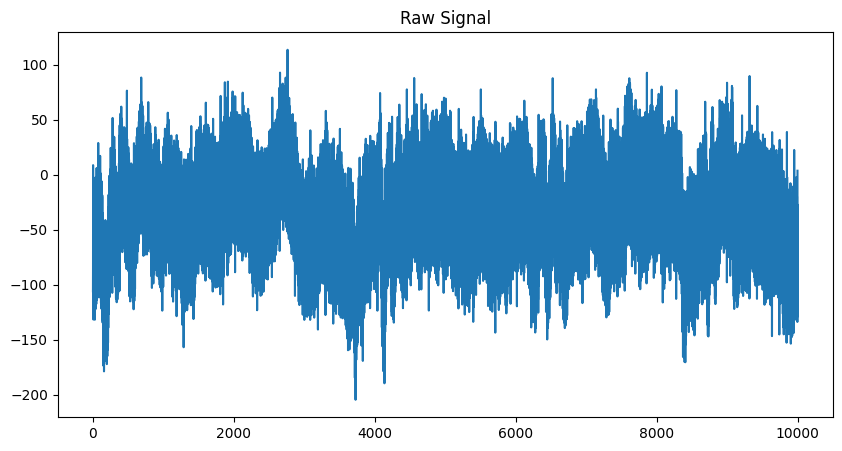

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(signal_data)
plt.title('Raw Signal')

Text(0.5, 1.0, 're_referenced_signal')

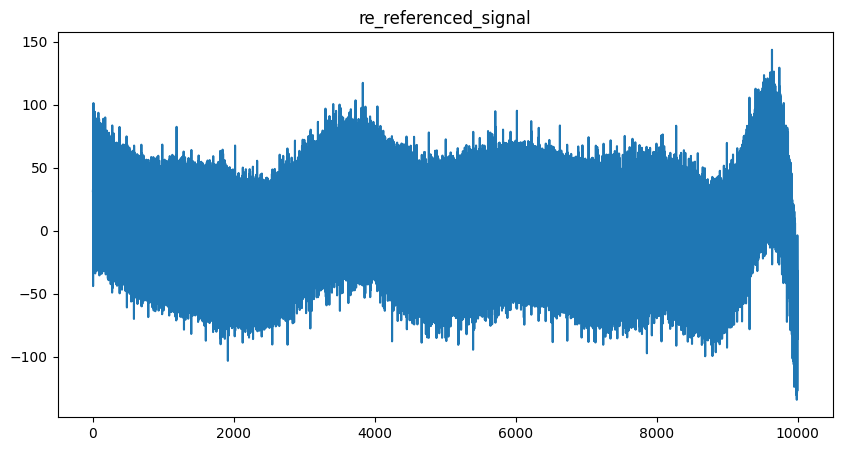

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(re_referenced_signal)
plt.title('re_referenced_signal')

Text(0.5, 1.0, 'epochs')

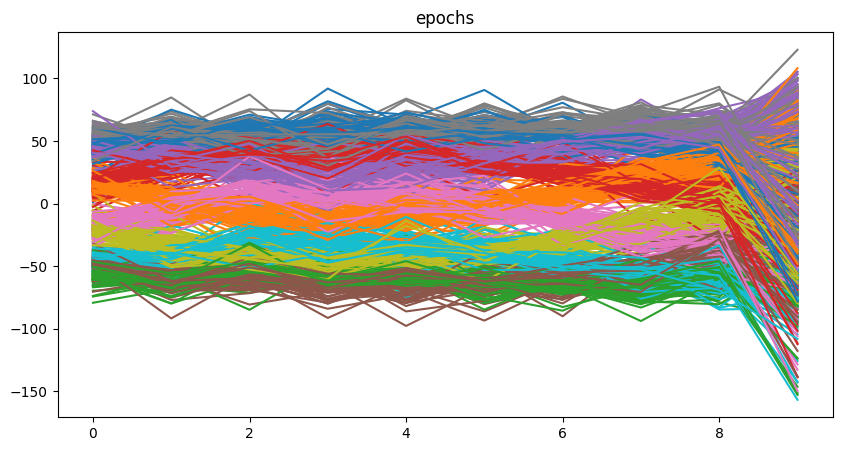

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(epochs)
plt.title('epochs')